In [1]:
import os
import tensorflow as tf
import numpy as np
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import PIL
import time
import functools
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

In [2]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
content_layers = ['block5_conv2'] 

In [3]:
def load_img(path_to_img,max_dim = 512):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [6]:
img_path='wikiartimages\\images\\abstract-expressionism\\466_golden-brown-painting-1944.jpg!Blog.jpg'

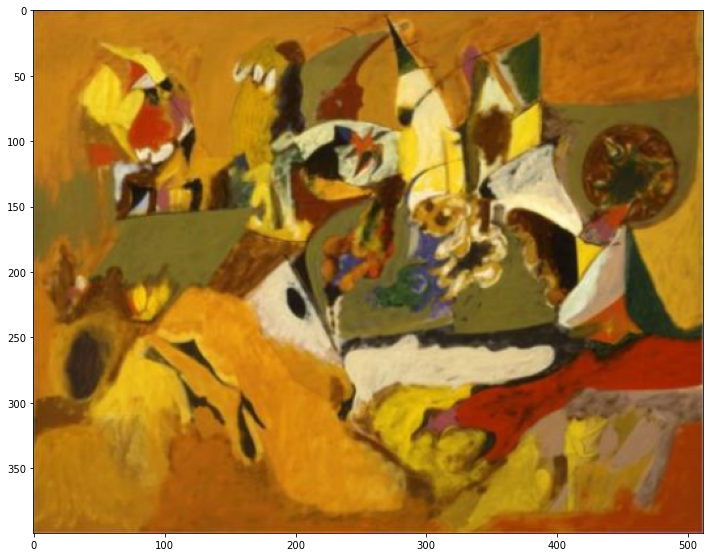

In [7]:
img_tensor=load_img(img_path)
imshow(img_tensor)

In [8]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [9]:
style_extractor=vgg_layers(style_layers)
style_output=style_extractor(img_tensor)

In [10]:
for name, output in zip(style_layers, style_output):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 400, 512, 64)
  min:  0.0
  max:  4.8009143
  mean:  0.49480805

block2_conv1
  shape:  (1, 200, 256, 128)
  min:  0.0
  max:  20.916552
  mean:  1.7012559

block3_conv1
  shape:  (1, 100, 128, 256)
  min:  0.0
  max:  67.66887
  mean:  1.8298311

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  171.64781
  mean:  8.855755

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  36.481102
  mean:  0.683059



In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

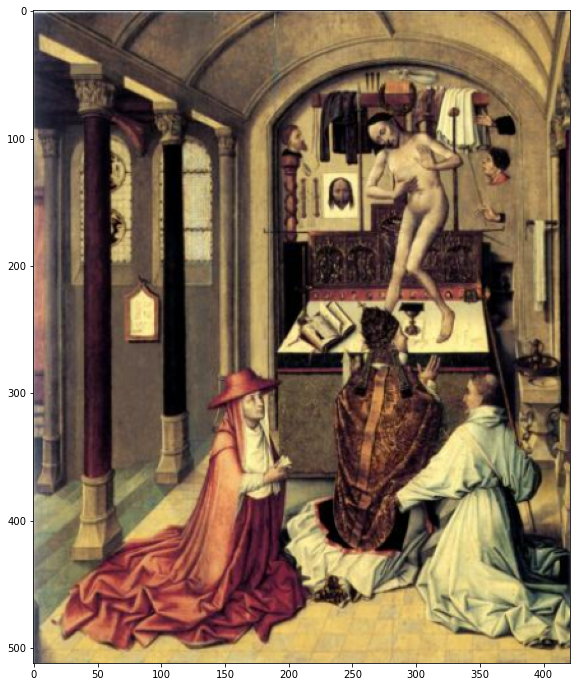

In [13]:
content_path='wikiartimages\\images\\northern-renaissance\\10_mass-of-saint-gregory.jpg!Blog.jpg'
content_tensor=load_img(content_path)
imshow(content_tensor)

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_tensor))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.050048023
    max:  14260.039
    mean:  531.08716

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  108735.445
    mean:  20532.145

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  438770.22
    mean:  22009.59

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4458548.5
    mean:  272857.06

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  87438.51
    mean:  1955.7517

Contents:
   block5_conv2
    shape:  (1, 32, 26, 512)
    min:  0.0
    max:  1067.3213
    mean:  17.178413


In [15]:
def make_npz(img_dir_path='wikiartimages\\images',grand_total=0,limit=500,target_path='wikiartimages\\stylematricesminmax\\',extractor=extractor,load_img=load_img):
    try:
        os.mkdir(target_path)
    except FileExistsError:
        pass
    with tqdm(total=limit*(len(os.listdir(img_dir_path)))) as pbar:
        for folder in os.listdir(img_dir_path):
            if folder != '.DS_Store':
                src_folder=img_dir_path+'\\'+folder
                target_folder=target_path+folder
                try:
                    os.mkdir(target_folder)
                except FileExistsError:
                    pass
                count=0
                all_img_names=os.listdir(src_folder)
                total=len(all_img_names)-1
                target_contents=set([f for f in os.listdir(target_folder)])
                for img_name in all_img_names[:limit]:
                    pbar.update(1)
                    pbar.set_description(folder+'/'+img_name)
                    if img_name != '.DS_Store':
                        count+=1
                        grand_total+=1
                        img_path=src_folder+'\\'+img_name
                        new_img_name=img_name[:img_name.find('.jpg')]
                        target_npz=target_folder+'\\'+new_img_name+'.npz'

                        if new_img_name+'.npz' not in target_contents:
                            #print(new_img_name)
                            try:
                                img_tensor=load_img(img_path)
                            except ValueError:
                                print('ValueError trying to load ',img_name)
                                continue
                            img_tensor=(2*(img_tensor-tf.math.reduce_min(img_tensor))/(tf.math.reduce_max(img_tensor)-tf.math.reduce_min(img_tensor)))-1
                            results = extractor(tf.constant(img_tensor))
                            target_dict={name: output.numpy() for name, output in sorted(results['style'].items())}
                            #print(target_dict)
                            np.savez(target_npz,**target_dict)
                            #print('{}/{} complete {}'.format(count,total,new_img_name))
                            #print('   read  from {}, write to {} {}/{} complete'.format(img_name,new_img_name+'.npz',count,total))

In [16]:
class StyleContentModelNoGram(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModelNoGram, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [17]:
extractor_two=StyleContentModelNoGram(style_layers,content_layers)

In [18]:
[v.shape for v in extractor_two(content_tensor)['style'].values()]

[TensorShape([1, 512, 421, 64]),
 TensorShape([1, 256, 210, 128]),
 TensorShape([1, 128, 105, 256]),
 TensorShape([1, 64, 52, 512]),
 TensorShape([1, 32, 26, 512])]

In [19]:
[v.shape for v in extractor_two(img_tensor)['style'].values()]

[TensorShape([1, 400, 512, 64]),
 TensorShape([1, 200, 256, 128]),
 TensorShape([1, 100, 128, 256]),
 TensorShape([1, 50, 64, 512]),
 TensorShape([1, 25, 32, 512])]

In [20]:
def load_img_padding(img_path,max_dim=512):
    img=load_img(img_path,max_dim = max_dim)
    img=tf.image.pad_to_bounding_box(img, 0, 0, max_dim, max_dim)
    return img

load_img_padding(img_path)

<tf.Tensor: shape=(1, 512, 512, 3), dtype=float32, numpy=
array([[[[0.8705883 , 0.7019608 , 0.5019608 ],
         [0.7532935 , 0.5846661 , 0.36953127],
         [0.76747864, 0.58777577, 0.3573223 ],
         ...,
         [0.780622  , 0.5891544 , 0.32801777],
         [0.7854167 , 0.605576  , 0.3705576 ],
         [0.81568635, 0.6509804 , 0.42352945]],

        [[0.74554414, 0.5617598 , 0.35039216],
         [0.6282494 , 0.4444651 , 0.22527462],
         [0.6317329 , 0.44400758, 0.20263053],
         ...,
         [0.6520106 , 0.45697594, 0.18112646],
         [0.660639  , 0.48093152, 0.23806827],
         [0.6982206 , 0.5373039 , 0.2946961 ]],

        [[0.78188735, 0.57906866, 0.35250002],
         [0.66102165, 0.46177393, 0.21692528],
         [0.66051716, 0.45422357, 0.19004223],
         ...,
         [0.63684916, 0.44539085, 0.14682157],
         [0.6531001 , 0.47670797, 0.2113648 ],
         [0.7052206 , 0.53703433, 0.27169117]],

        ...,

        [[0.        , 0.        , 

In [22]:
make_npz(target_path='wikiartimages\\stylelayeroutput\\',extractor=extractor_two,limit=150,load_img=load_img_padding)

mannerism-late-renaissance/1042_votive-portrait-of-doge-sebastiano-venier-1582.jpg!Blog.jpg:  45%|▍| 1909/4200 [00:56<0


OSError: [Errno 28] No space left on device